In [20]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [26]:
def gen_samples(m_samples, n_features):
    X = np.zeros((m_samples, n_features))
    for i in range(m_samples):
        u = np.random.randint(low=0, high=11)
        s = np.random.randint(low=1, high=5)*(np.random.rand(1)[0]+0.0001)
        
        sample = np.random.normal(loc=u, scale=s, size=10000)       
        hist = np.histogram(sample, bins=np.linspace(0,10,n_features+1))[0]
        
        X[i,:] = hist
    
    return X

def Xplot(X, ind):
    fig, axs = plt.subplots(len(ind),1, figsize=(8,12))
    for i, ax in zip(ind, axs.ravel()):
        ax.plot(X[i,:])
        
    plt.show()

## Original Samples

In [27]:
X = gen_samples(1000, 100)

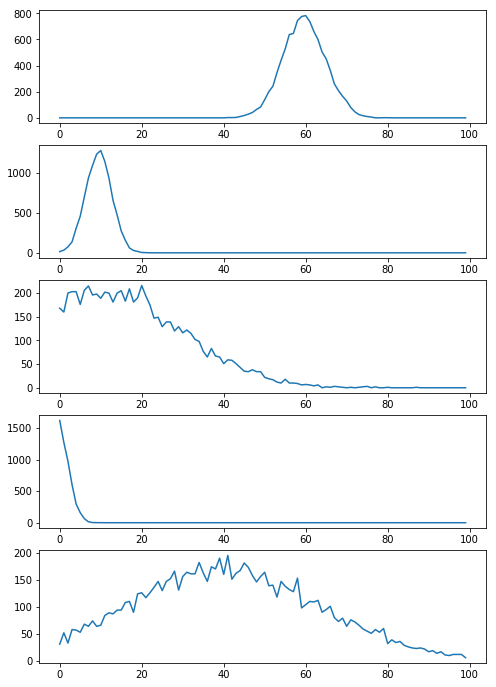

In [28]:
Xplot(X, range(5))

## Transformed Samples

In [29]:
pca = PCA()
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

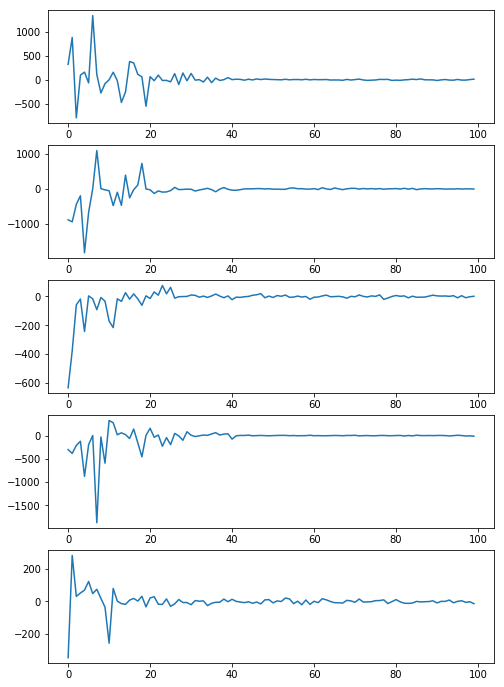

In [32]:
Y_gt = pca.transform(X)
Xplot(Y_gt, range(5))

# Pickle

In [33]:
import pickle

pickle.dump(pca, 'saved_models/pca.pickle')

del pca

pca = pickle.load('saved_models/pca.pickle')

TypeError: file must have a 'write' attribute

# Dill

In [34]:
import dill

dill.dump(pca, 'saved_models/pca.dill')

del pca

pca = dill.load('saved_models/pca.dill')

TypeError: file must have a 'write' attribute

# Joblib

In [35]:
import joblib

joblib.dump(pca, 'saved_models/pca.joblib')

del pca

pca = joblib.load('saved_models/pca.joblib')

In [36]:
Y_joblib = pca.transform(X)

np.allclose(Y_gt, Y_joblib)

True

# PyTorch

In [37]:
import torch
import torch.nn as nn

In [41]:
class transform_pca(nn.Module):
    def __init__(self, trans):
        super(transform_pca, self).__init__()
        self.trans = trans

    def forward(self, X):
        return self.trans(X)

In the following I show that the pca transform function can be saved in a pytorch class

In [43]:
pca_pytorch = transform_pca(pca.transform)

Y_torch = pca_pytorch.forward(X)

np.allclose(Y_gt, Y_torch)

True

Maybe the pytorch class is referencing global variables in the pca class though?? Next I show that this is not the case and the pca transform function must have transferred the eigenvectors to the pytorch class

In [44]:
del pca

Y_torch = pca_pytorch.forward(X)

np.allclose(Y_gt, Y_torch)

True

Lastly, I check that it is possible to save the pytorch class and reload the pca transform function.

In [45]:
torch.save(pca_pytorch, 'saved_models/pca.pytorch')

del pca_pytorch

pca_pytorch = torch.load('saved_models/pca.pytorch')

/anaconda3/envs/ml/lib/python3.7/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type transform_pca. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [47]:
Y_torch_fromdisk = pca_pytorch.forward(X)

np.allclose(Y_gt, Y_torch_fromdisk)

True

Damn it works. This means we can save an entire workflow in a pytorch class and save it. Really impressive stuff.